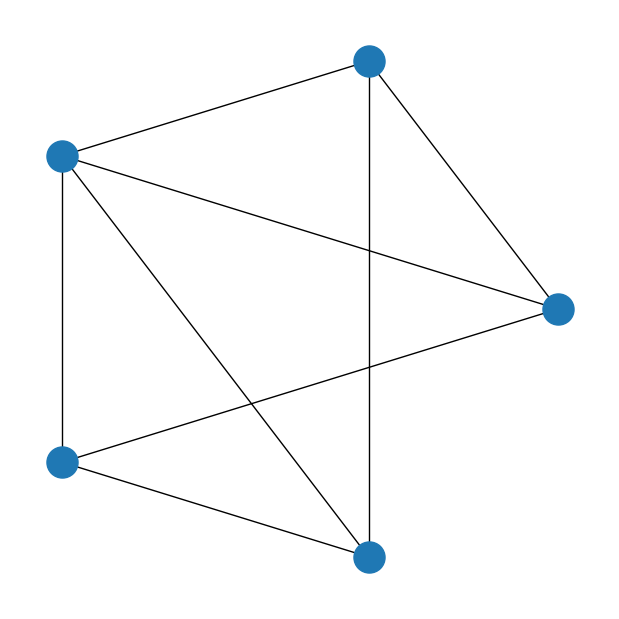

In [ ]:
import numpy as np
from src.viz import simple_graph_from_adj, generate_sbm, plot_sbm, MySbmFromScratch
import networkx as nx
import torch
import matplotlib.pyplot as plt

matrix = np.array([[0,1,1,1,0],
                  [1,0,1,0,1],
                  [1,1,0,1,1],
                  [1,0,1,0,1],
                  [0,1,1,1,0]])

simple_graph_from_adj(matrix, labels=False)

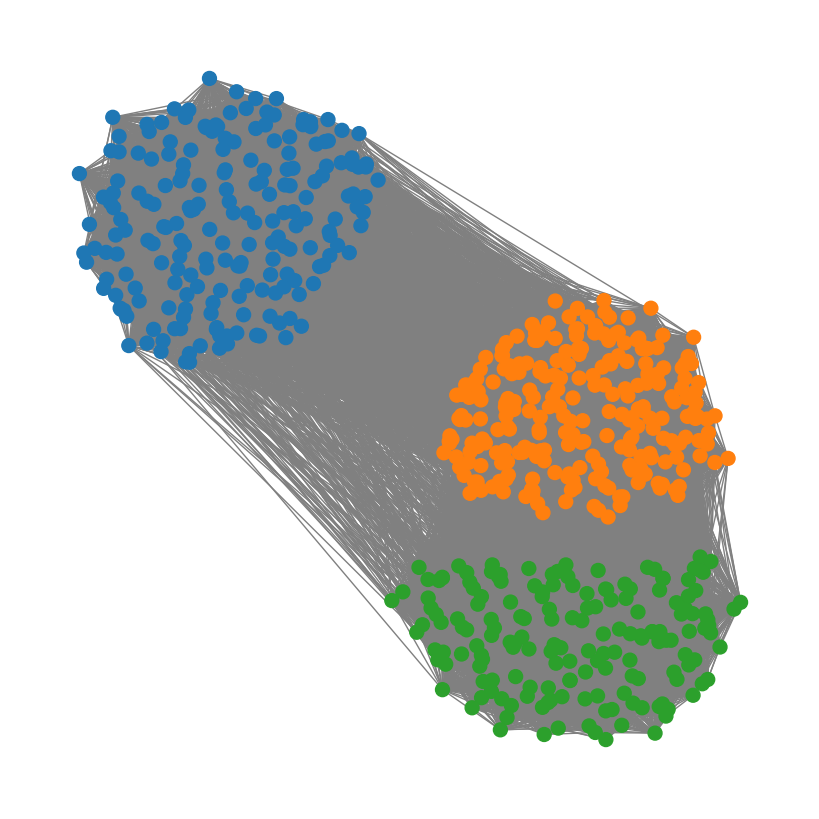

In [2]:
n_classes = [200, 250, 170]

probs = np.array([
    [0.4, 0.03, 0.01],
    [0.03, 0.5, 0.1],
    [0.01, 0.1, 0.4]
])

G = generate_sbm(n_classes, probs)

plot_sbm(G, n_classes)


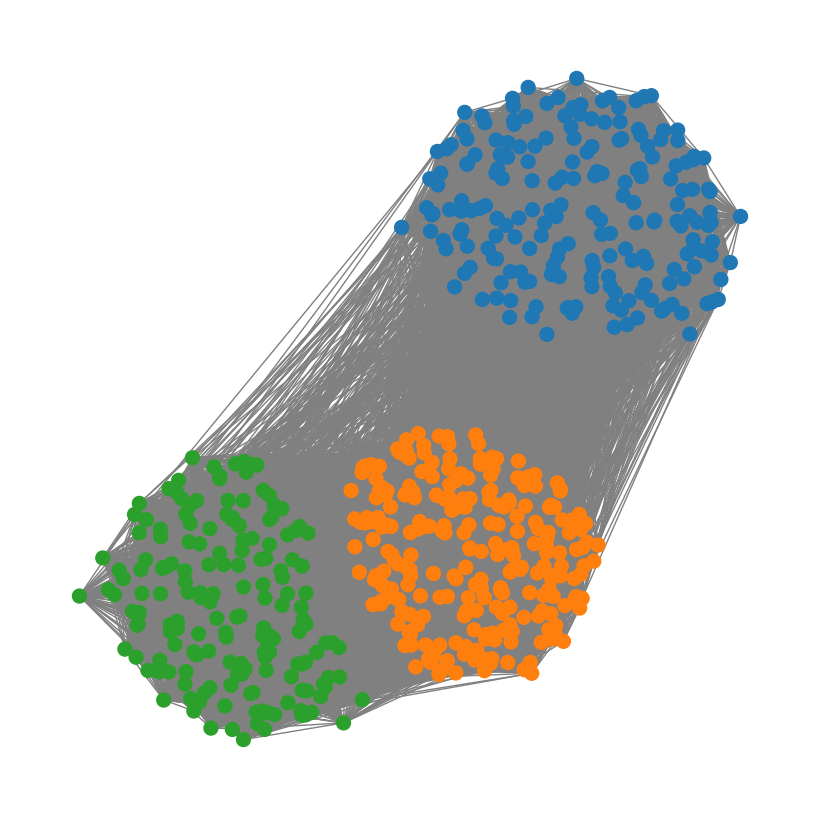

In [92]:
sbm = MySbmFromScratch()

sbm.generate_graph(n_classes = n_classes, probs = probs)
sbm.plot_graph()


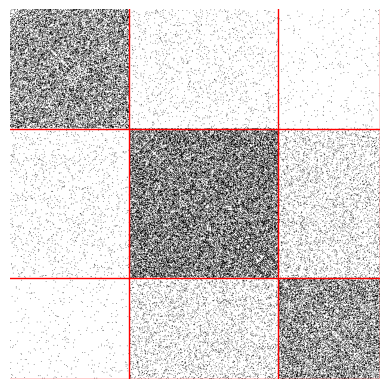

In [4]:
sbm.plot_adj()

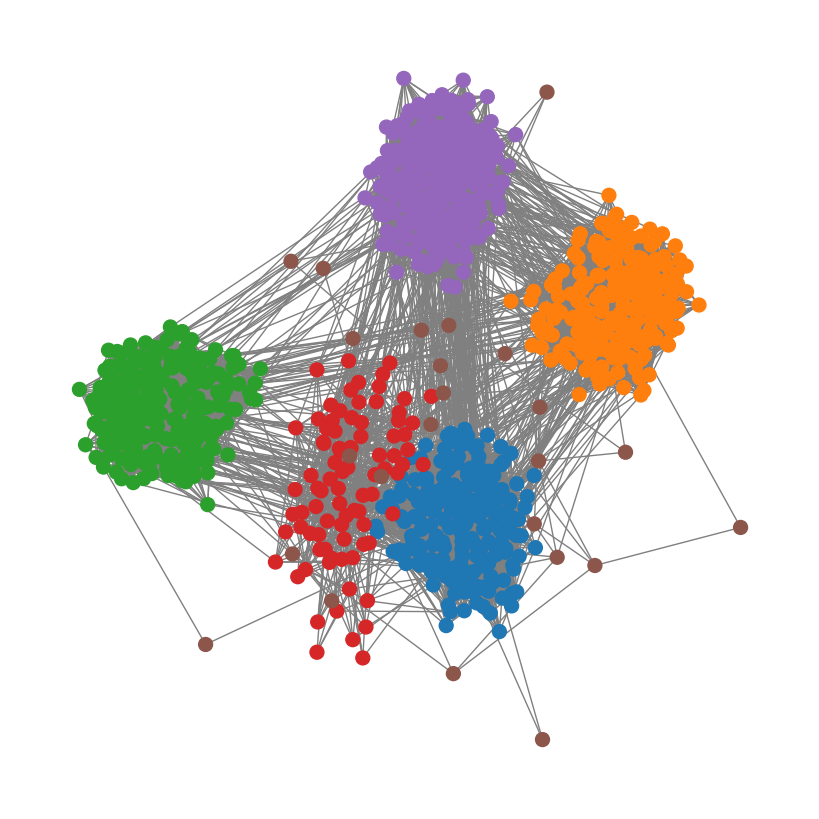

In [40]:
sbm = MySbmFromScratch()

sbm.generate_graph(N = 1000, K=6, _lambda=0.1, multiplier=0.08, alpha=1.5)
sbm.plot_graph()


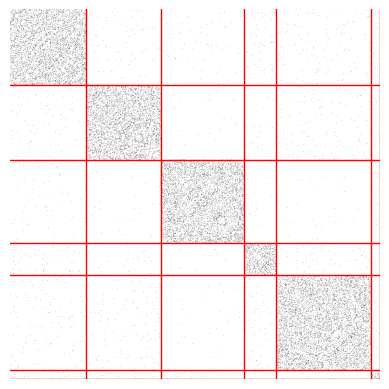

In [41]:
sbm.plot_adj()

In [42]:
from tqdm import trange

In [106]:
class MixtureModel():
    def __init__(self, X, n, k):
        self.N = n
        self.K = k
        self.logs_like = []
        self.X = torch.tensor(X, dtype=torch.float)

        tau = torch.rand(n, k)
        tau /= tau.sum(dim=1, keepdim=True)
        #tau = torch.tensor(np.array([[0.1,0.8,0.1],[0.7,0.1,0.2],[0.2,0.1,0.7], [0.3,0.4,0.3], [0.1,0.1,0.9]]), dtype=torch.float)
        self.tau = tau


    def comp_alpha_pi(self):
        mask = torch.ones(self.N, self.N, dtype=bool)#~torch.eye(self.N, dtype=bool)

        numerator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, self.X * mask)

        denominator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, mask.float())

        pi = numerator / denominator

        alpha = self.tau.mean(dim=0)   

        return alpha, pi  # (K), (KxK)
        
    def compute_tau(self, alpha, pi, tau, epsilon=1e-10):
        N, K = tau.size()

        pi = torch.clamp(pi, min=epsilon, max=1 - epsilon)

        X_expanded = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        pi_expanded = pi.unsqueeze(0).unsqueeze(0)  # (1, 1, K, K)

        log_b = X_expanded * torch.log(pi_expanded) + (1 - X_expanded) * torch.log(1 - pi_expanded)

        tau_expanded = tau.unsqueeze(0).unsqueeze(-1)  # (1, N, K, 1)
        log_b_tau = log_b * tau_expanded  # (N, N, K, K)

        # J'ai mis le mask au cas ou mais avec les données synthetiques il sert a rien
        # car je défini adj tel que la diagonale = 0
        mask = 1 - torch.eye(N, device=self.X.device).unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        masked_log_b_tau = log_b_tau * mask

        sum_jl = torch.einsum('ijnq->iq', masked_log_b_tau)  # (N, K)

        log_alpha = torch.log(alpha + epsilon).unsqueeze(0)  # (1, K)
        log_tau = log_alpha + sum_jl
        log_tau = log_tau - log_tau.logsumexp(dim=1, keepdim=True) # Normalisation comme on est dans le log

        tau_new = torch.exp(log_tau) # on met a l'exp le tout 

        return tau_new

    def _likelihood(self, alpha, pi, tau):
        term1 = torch.einsum('iq,q->', tau, torch.log(alpha))

        X_unsqueezed = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        log_b = (
            X_unsqueezed * torch.log(pi) + (1 - X_unsqueezed) * torch.log(1 - pi)
        )
        term2 = 0.5 * torch.einsum('iq,jl,ijql->', tau, tau, log_b)

        epsilon = 1e-10
        term3 = -torch.einsum('iq,iq->', tau, torch.log(tau + epsilon))

        result = term1 + term2 + term3
        return result

    def _fixed_point_algorithm(self, alpha, pi, tau_initial, tol=1e-6, max_iter=100):

        tau = tau_initial.clone()
        for i in range(max_iter):
            tau_new = self.compute_tau(alpha, pi, tau)
            
            # Peut être changer le critère je suis pas familier avec le fixed point
            diff = torch.norm(tau_new - tau, p='fro')
            if diff < tol:
                break
            
            tau = tau_new

        return tau
    
    def em(self, max_it=50, tolerance=1e-10):
        prev_value = -np.inf
        for _ in trange(max_it):
            alpha, pi = self.comp_alpha_pi() # M step
            self.tau = self._fixed_point_algorithm(alpha, pi, self.tau) # E step
            likeli = self._likelihood(alpha, pi, self.tau) # compute likelihood
            self.logs_like.append(likeli) # keep in logs the log likelihood
            if abs(likeli - prev_value) < tolerance: # 
                break
            else:
                prev_value=likeli

        return alpha, pi, self.tau

test = MixtureModel(sbm.adj, sbm.adj.shape[0], 3)
_, __, tau = test.em()


 10%|█         | 5/50 [00:02<00:18,  2.37it/s]


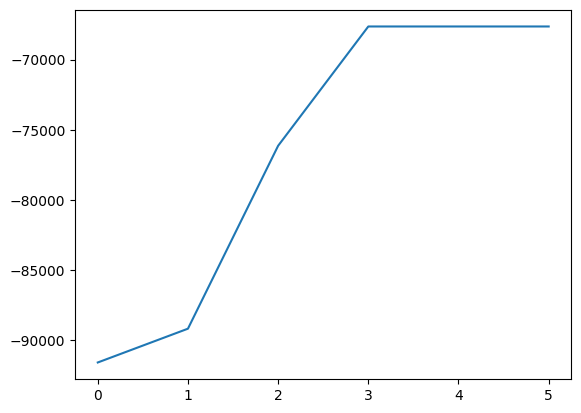

In [109]:
plt.plot(test.logs_like)
plt.show()

In [110]:
probs

array([[0.4 , 0.03, 0.01],
       [0.03, 0.5 , 0.1 ],
       [0.01, 0.1 , 0.4 ]])

In [111]:
__

tensor([[0.4048, 0.0980, 0.0098],
        [0.0980, 0.4986, 0.0296],
        [0.0098, 0.0296, 0.3926]])

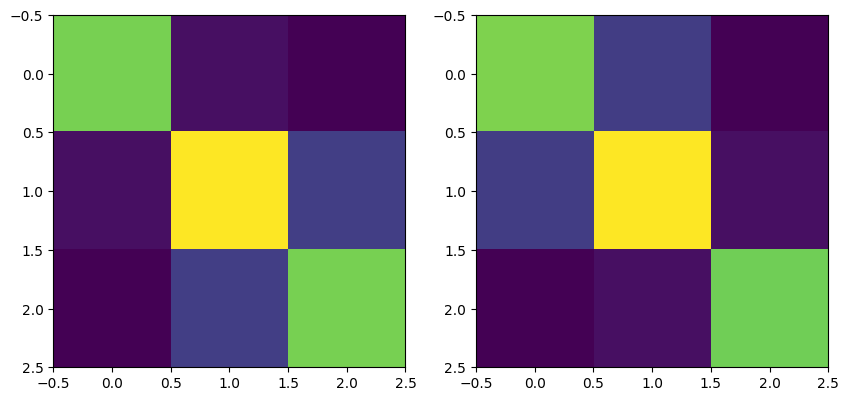

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(probs)
axes[1].imshow(__)